In [717]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from datetime import date
import requests
from sklearn.model_selection import train_test_split
from pandas.plotting import scatter_matrix
from datetime import datetime

import seaborn as sns
sns.set()

import nba_api
from nba_api.stats.static import teams
from nba_api.stats.endpoints import leaguegamefinder


# Data Gathering and Cleaning

In [2]:
# #Create 'nba_seasons' dataframe from nba_api. 
# #nba_api downloads last 30,000 games of NBA, WNBA, D-Leagues etc.
# #Cleans data removing all but NBA games for 2015-16, 2016-17, 2017-18, 2018-19 seasons
%run ./NBA_Data_Gathering.ipynb

In [1421]:
train_set, test_set = train_test_split(nba_seasons[0], test_size=0.2, shuffle=False)

In [1422]:
season = train_set.copy()

In [1423]:
season.head()

,GAME_ID,TEAM_ID,GAME_DATE,MATCHUP,MIN,PTS,FGM,FGA,FG_PCT,FG3M,...,OPP_FTA,OPP_FT_PCT,OPP_OREB,OPP_DREB,OPP_REB,OPP_AST,OPP_STL,OPP_BLK,OPP_TOV,OPP_PF
4466,0021500001,1610612765,2015-10-27,0,239,106,37,96,0.385,12,...,15,0.800,7,33,40,22,9,4,15,25
4467,0021500001,1610612737,2015-10-27,1,239,94,37,82,0.451,8,...,26,0.769,23,36,59,23,5,3,15,15
4468,0021500002,1610612739,2015-10-27,0,240,95,38,94,0.404,9,...,23,0.696,7,40,47,13,6,10,13,22
4469,0021500002,1610612741,2015-10-27,1,240,97,37,87,0.425,7,...,17,0.588,11,39,50,26,5,7,10,21
4470,0021500003,1610612744,2015-10-27,1,241,111,41,96,0.427,9,...,27,0.704,8,25,33,21,9,3,18,26


In [1424]:
#  season.corr()['COMBINED_FINAL_SCORE'].sort_values(ascending=False)

In [1425]:
# attributes = ['COMBINED_FINAL_SCORE', 'PTS', 'FGM', 'FG_PCT', 'AST', 'FG3M', 'FTM', 'FG3_PCT', 'FTA', 'PF', 'FGA', 'MIN']
# scatter_matrix(season[attributes], figsize=(20,20))

# plt.show()



In [1426]:
# season.plot(kind='scatter', x='PTS', y='COMBINED_FINAL_SCORE', alpha=0.1)
# plt.show()

In [1427]:
# teams_df.loc[teams_df['TEAM_ID']==1610612749][['nickname']].values

# Team Metrics

In [1428]:
#returns 'TEAM_ID' from 'team_name' input
def team_to_id(team_name):
    team = teams_df.loc[teams_df['nickname'] == str(team_name)][['TEAM_ID']].values
    return team[0,0]

In [1429]:
# teams_df

In [1430]:
#returns stats for a given 'team_id' and for a given 'season_no'
def team_stats(team_id, season):
    return season.loc[season['TEAM_ID'] == team_id]

In [1431]:
#finds 'TEAM_ID' for a given team name
team_A = team_to_id('Lakers')

#gets stats for team_A
team_A_stats = team_stats(team_A, season).reset_index(drop=True)
# team_A_stats.head()

In [1432]:
team_B = team_to_id('Spurs')
team_B_stats = team_stats(team_B, season).reset_index(drop=True)
# team_B_stats.tail()

In [1433]:
#identifies back-to-back games for a given team and labels these as 1 in output dataframe
#with non-back-to-back dataframes labeled as 0
def back2back(team):
    dt = pd.DataFrame(team_A_stats.GAME_DATE)
    days_between = list(map(lambda x : (datetime.strptime(dt.GAME_DATE.iloc[x+1], '%Y-%m-%d')\
    -datetime.strptime(dt.GAME_DATE.iloc[x], '%Y-%m-%d')).days, list(range(len(team_A_stats)-1))))
    days_between = list(map(lambda x : int(days_between[x]==1), list(range(len(days_between)))))
    days_between = pd.DataFrame({'back-to-back':days_between})
    days_between = pd.DataFrame({'BACK-TO-BACK':pd.concat([pd.Series([0]), days_between['back-to-back']]).reset_index(drop=True)})
    return days_between


In [1477]:
backtoback_A = back2back(team_A)
backtoback_B = back2back(team_B)

In [1478]:
team_A_df = team_A_stats[['MATCHUP']].merge(backtoback, left_index=True, right_index=True)
team_B_df = team_B_stats[['MATCHUP']].merge(backtoback, left_index=True, right_index=True)

In [1479]:
team_A_df['PTS'] = pd.DataFrame(team_A_stats.PTS)
team_B_df['PTS'] = pd.DataFrame(team_B_stats.PTS)

In [1480]:
# team_A_df['PTS_ema4'] = team_A_df.PTS.ewm(span=4, adjust=False).mean()
team_A_df['PTS_ema8'] = team_A_df.PTS.ewm(span=8, adjust=False).mean()
# team_A_df['PTS_ema12'] = team_A_df.PTS.ewm(span=12, adjust=False).mean()

# team_B_df['PTS_ema4'] = team_B_df.PTS.ewm(span=4, adjust=False).mean()
team_B_df['PTS_ema8'] = team_B_df.PTS.ewm(span=8, adjust=False).mean()
# team_B_df['PTS_ema12'] = team_B_df.PTS.ewm(span=12, adjust=False).mean()

In [1483]:
team_A_df['OPP_PTS'] = team_A_stats['OPP_PTS']
team_B_df['OPP_PTS'] = team_B_stats['OPP_PTS']

In [1484]:
# team_A_df['OPP_PTS_ema4'] = team_A_df.OPP_PTS.ewm(span=4, adjust=False).mean()
team_A_df['OPP_PTS_ema8'] = team_A_df.OPP_PTS.ewm(span=8, adjust=False).mean()
# team_A_df['OPP_PTS_ema12'] = team_A_df.OPP_PTS.ewm(span=12, adjust=False).mean()

# team_B_df['OPP_PTS_ema4'] = team_B_df.OPP_PTS.ewm(span=4, adjust=False).mean()
team_B_df['OPP_PTS_ema8'] = team_B_df.OPP_PTS.ewm(span=8, adjust=False).mean()
# team_B_df['OPP_PTS_ema12'] = team_B_df.OPP_PTS.ewm(span=12, adjust=False).mean()

In [1487]:
team_A_df = team_A_df[['PTS', 'MATCHUP', 'BACK-TO-BACK', 'PTS_ema8', 'OPP_PTS_ema8']]
team_A_df

,PTS,MATCHUP,BACK-TO-BACK,PTS_ema8,OPP_PTS_ema8
0,111,1,0,111.000000,112.000000
1,114,0,0,111.666667,116.444444
2,93,1,0,107.518519,113.456790
3,109,1,0,107.847737,114.910837
4,104,0,0,106.992684,111.152873
...,...,...,...,...,...
61,107,0,1,105.637263,112.729906
62,77,1,0,99.273427,111.234371
63,112,1,0,102.101554,107.626733
64,107,1,0,103.190098,105.487459


In [1488]:
team_A_df.corr()['PTS'].sort_values(ascending=False)

PTS             1.000000
PTS_ema8        0.596953
OPP_PTS_ema8    0.329729
BACK-TO-BACK    0.076821
MATCHUP        -0.075310
Name: PTS, dtype: float64

In [1489]:
team_B_df = team_B_df[['PTS', 'MATCHUP', 'BACK-TO-BACK', 'PTS_ema8', 'OPP_PTS_ema8']]
team_B_df

,PTS,MATCHUP,BACK-TO-BACK,PTS_ema8,OPP_PTS_ema8
0,106,0,0,106.000000,112.000000
1,102,1,0,105.111111,103.777778
2,95,0,0,102.864198,100.049383
3,94,0,0,100.894376,96.482853
4,99,0,0,100.473403,97.708886
...,...,...,...,...,...
61,104,1,1,102.137930,91.778451
62,91,0,0,99.662834,93.383239
63,116,0,0,103.293316,92.853631
64,109,1,0,104.561468,94.663935


In [1490]:
team_B_df.corr()['PTS'].sort_values(ascending=False)

PTS             1.000000
PTS_ema8        0.645710
MATCHUP         0.116538
OPP_PTS_ema8    0.089715
BACK-TO-BACK    0.068109
Name: PTS, dtype: float64

In [1468]:
# attributes = ['PTS','MATCHUP','BACK-TO-BACK','PTS_ema8','OPP_PTS','OPP_PTS_ema8']
# scatter_matrix(team_B_df[attributes], figsize=(20,20))

# plt.show()


In [1443]:
#finds total points scored by teams A and B during their matchups with each other
team_AB_matchups = team_A_stats[['PTS','OPP_PTS']].loc[team_A_stats['OPP_TEAM_ID']==team_B]
team_AB_matchups.columns = ['PTS_A', 'PTS_B']
team_AB_matchups

,PTS_A,PTS_B
22,87,109
44,95,108
52,102,106
55,113,119


In [1444]:
#calculates exponential moving average (& exponential std) of points scored by
#teams A & B in their matchups with each other
AB_matchups_ema = team_AB_matchups.ewm(com=0.5).mean().iloc[-1:]
AB_matchups_ema_std = team_AB_matchups.ewm(com=0.5).std().iloc[-1:]
AB_matchups_ema.columns = ['EMA_PTS_A', 'EMA_PTS_B']
AB_matchups_ema_std.columns = ['EMA_STD_PTS_A', 'EMA_STD_PTS_B']
AB_matchups_ema[['EMA_STD_PTS_A', 'EMA_STD_PTS_B']] = AB_matchups_ema_std
AB_matchups_ema = AB_matchups_ema[['EMA_PTS_A','EMA_STD_PTS_A','EMA_PTS_B','EMA_STD_PTS_B']]
AB_matchups_ema

,EMA_PTS_A,EMA_STD_PTS_A,EMA_PTS_B,EMA_STD_PTS_B
55,108.525,9.963974,115.0,8.301992


In [1445]:
#sum of exponential moving averages for points scored by teams A & B in games
#played between each other
AB_matchups_ema_sum = AB_matchups_ema['EMA_PTS_A'].values + AB_matchups_ema['EMA_PTS_B'].values
AB_matchups_ema_sum

array([223.525])

In [1446]:
AB_matchups_ema_sum_std = np.sqrt(AB_matchups_ema['EMA_STD_PTS_A'].values**2 + AB_matchups_ema['EMA_STD_PTS_B'].values**2)
AB_matchups_ema_sum_std

array([12.96934255])

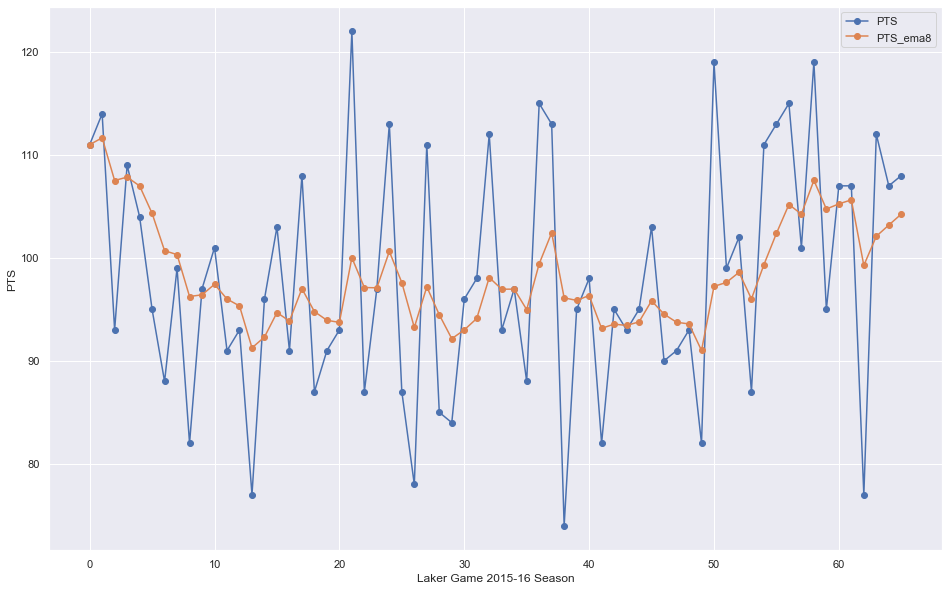

In [1496]:

team_A_df[['PTS','PTS_ema8']].plot(marker='o', figsize=(16,10))
plt.xlabel('Laker Game 2015-16 Season')
plt.ylabel('PTS')
plt.show()

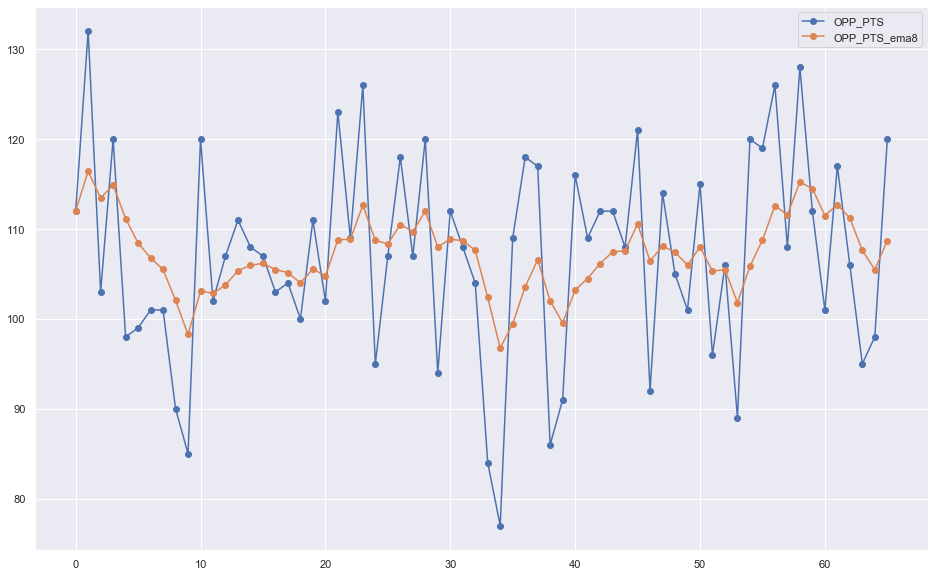

In [1448]:

team_A_df[['OPP_PTS','OPP_PTS_ema8']].plot(marker='o', figsize=(16,10))
plt.show()

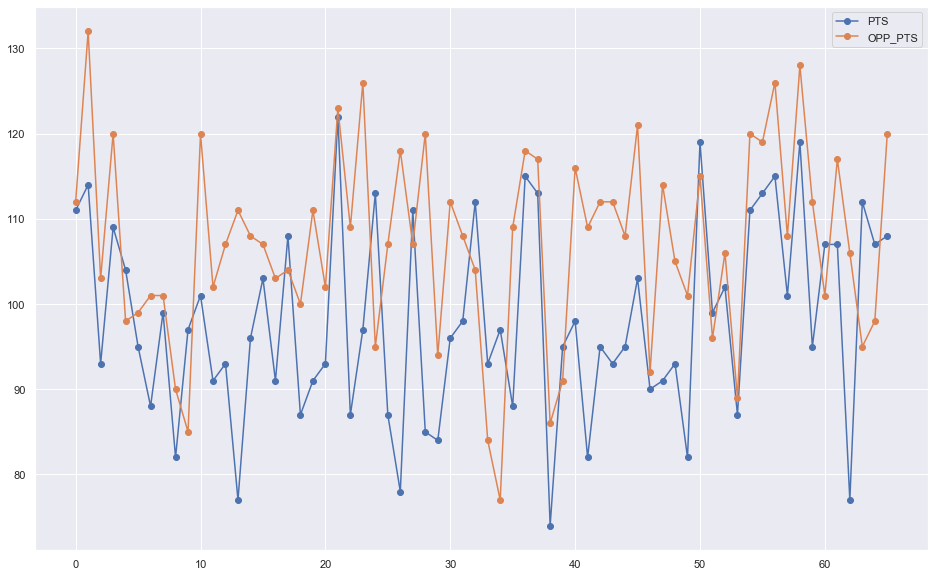

In [1449]:

team_A_stats[['PTS','OPP_PTS']].plot(marker='o', figsize=(16,10))
plt.show()

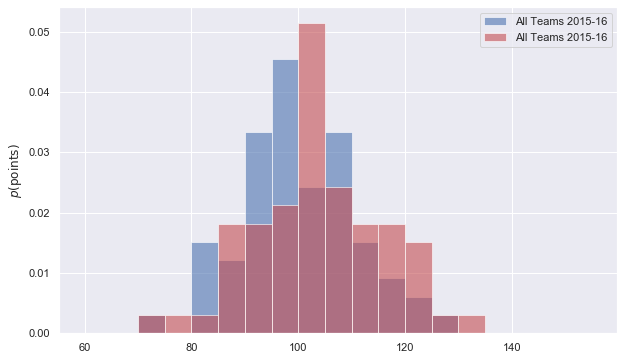

In [359]:
#Per season average points per game for all teams

bins = list(range(60, 160, 5))

fig, axes = plt.subplots(1,1, figsize=(10,6))
ax0 = axes

ax0.hist(team_A['PTS'], density=True, 
                         color='b', alpha=0.6, bins=bins, label='All Teams 2015-16')

ax0.hist(team_A['OPP_PTS'], density=True, 
                         color='r', alpha=0.6, bins=bins, label='All Teams 2015-16')

ax0.legend()

plt.ylabel(r'$p(\rm points)$')

plt.show()




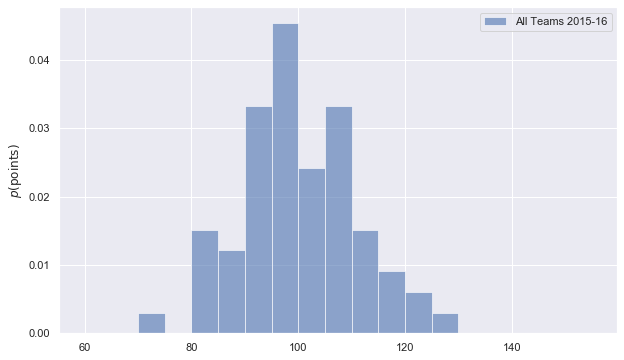

In [353]:
#Per season average points per game for all teams

bins = list(range(60, 160, 5))

fig, axes = plt.subplots(1,1, figsize=(10,6))

ax0 = axes

ax0.hist(team_A['PTS'], density=True, 
                         color='b', alpha=0.6, bins=bins, label='All Teams 2015-16')

ax0.legend()

plt.ylabel(r'$p(\rm points)$')

plt.show()



In [1459]:
# team = team_A.drop(['TEAM_ID'], axis=1)

In [1460]:
AB_corr = team_A[['PTS','OPP_TEAM_ID', 'OPP_MATCHUP', 'OPP_MIN',
       'OPP_PTS', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV',
       'OPP_PF']]

/Users/complexphenom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  """


IndexError: invalid index to scalar variable.

In [259]:
AB_corr.corr()['PTS'].sort_values(ascending=False)

PTS            1.000000
OPP_PTS        0.409298
OPP_FTM        0.374517
OPP_PF         0.365410
OPP_FTA        0.301458
OPP_TOV        0.270515
OPP_FGM        0.266248
OPP_MIN        0.232715
OPP_FT_PCT     0.223028
OPP_FGA        0.191429
OPP_FG_PCT     0.163319
OPP_AST        0.162129
OPP_FG3A       0.080209
OPP_OREB       0.079042
OPP_FG3M       0.019144
OPP_FG3_PCT   -0.025076
OPP_STL       -0.047996
OPP_BLK       -0.122633
OPP_REB       -0.138644
OPP_DREB      -0.226076
OPP_TEAM_ID   -0.267681
OPP_MATCHUP   -0.281807
Name: PTS, dtype: float64

In [248]:
# attributes = ['PTS','OPP_PF','OPP_PTS', 'OPP_FGM','OPP_MIN',
#               'OPP_FG_PCT', 'OPP_AST','OPP_FGA']
# scatter_matrix(season[attributes], figsize=(20,20))

# plt.show()

In [264]:
BA_corr = team_A[['OPP_PTS','TEAM_ID', 'MATCHUP', 'MIN',
       'PTS', 'FGM', 'FGA', 'FG_PCT', 'FG3M', 'FG3A',
       'FG3_PCT', 'FTM', 'FTA', 'FT_PCT', 'OREB',
       'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV',
       'PF']]

In [363]:
team_A[['PTS', 'OPP_PTS']].describe()


,PTS,OPP_PTS
count,66.000000,66.000000
mean,99.439394,103.121212
std,11.267556,12.097699
min,70.000000,74.000000
25%,91.000000,95.000000
50%,99.000000,102.500000
75%,107.000000,111.000000
max,128.000000,131.000000


In [34]:
# plt.plot(list(range(len(lakers))), list(lakers['PTS'].rolling(1).mean()))
# plt.show()

In [ ]:
# nba_seasons[0].hist(bins=50, figsize=(20,24))
# plt.show()

# Team Stats per Season

In [299]:
season.columns

Index(['GAME_ID', 'TEAM_ID', 'GAME_DATE', 'MATCHUP', 'MIN', 'PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'COMBINED_FINAL_SCORE', 'OPP_TEAM_ID', 'OPP_MATCHUP', 'OPP_MIN',
       'OPP_PTS', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV',
       'OPP_PF'],
      dtype='object')

In [300]:
all_teams_means = season.groupby(by=['TEAM_ID']).mean()[['PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'OPP_PTS', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV',
       'OPP_PF']]
# all_teams_means

all_teams_std = season.groupby(by=['TEAM_ID']).std()[['PTS', 'FGM',
       'FGA', 'FG_PCT', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM', 'FTA', 'FT_PCT',
       'OREB', 'DREB', 'REB', 'AST', 'STL', 'BLK', 'TOV', 'PF',
       'OPP_PTS', 'OPP_FGM', 'OPP_FGA', 'OPP_FG_PCT', 'OPP_FG3M', 'OPP_FG3A',
       'OPP_FG3_PCT', 'OPP_FTM', 'OPP_FTA', 'OPP_FT_PCT', 'OPP_OREB',
       'OPP_DREB', 'OPP_REB', 'OPP_AST', 'OPP_STL', 'OPP_BLK', 'OPP_TOV',
       'OPP_PF']]
# all_teams_std

In [463]:
best_offenses = pd.DataFrame(all_teams_means['PTS'].sort_values(ascending=False))
best_offenses = best_offenses.reset_index()
# best_offenses

In [464]:
worst_defenses = pd.DataFrame(all_teams_means['OPP_PTS'].sort_values(ascending=False))
worst_defenses = worst_defenses.reset_index()
# worst_defenses

In [468]:
master_df = pd.DataFrame(all_teams_means[['PTS', 'OPP_PTS']])
master_df

,PTS,OPP_PTS
TEAM_ID,,
1610612737,102.059701,98.626866
1610612738,106.106061,101.924242
1610612739,103.907692,97.476923
1610612740,102.692308,105.953846
1610612741,101.515625,102.875000
1610612742,102.378788,102.863636
1610612743,102.136364,104.181818
1610612744,115.461538,104.569231
1610612745,105.772727,107.030303


In [294]:
# all_teams_std[['PTS','OPP_PTS']]